In [17]:
# Name Hemant Bhambhu
# Email hkbhambhu@gmail.com

In [1]:
#importing necessary files

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import f1_score


In [2]:
# helper function to download the data

#from download_data import download_files
# download_files()

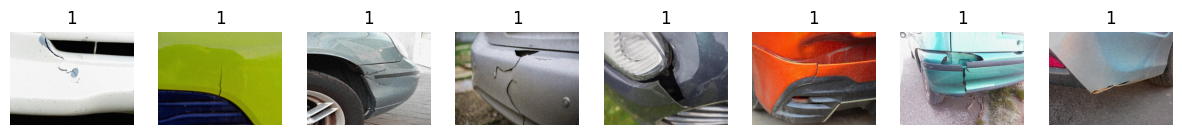

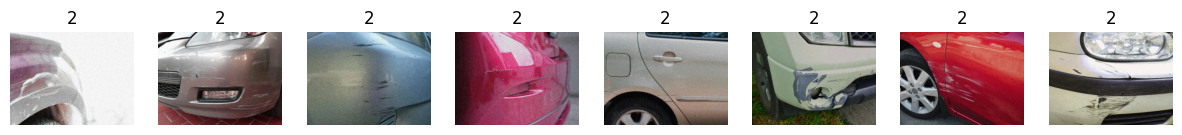

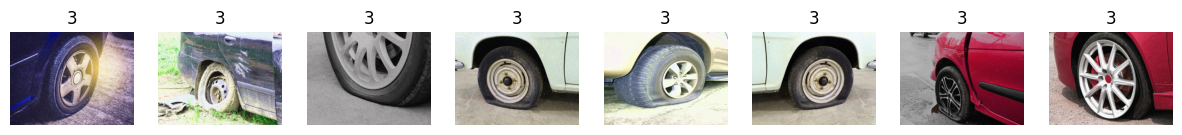

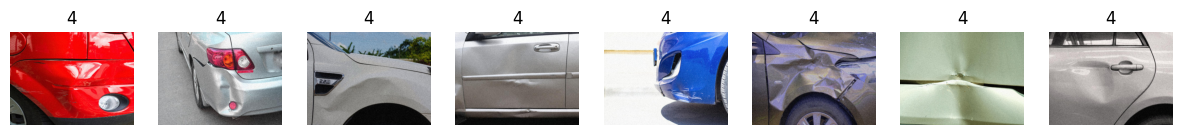

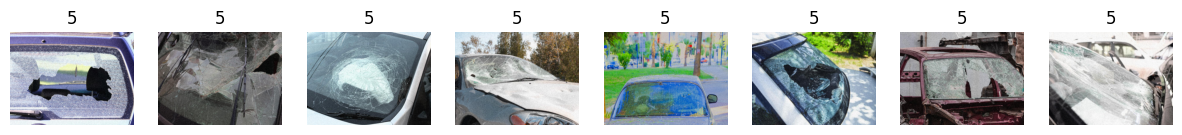

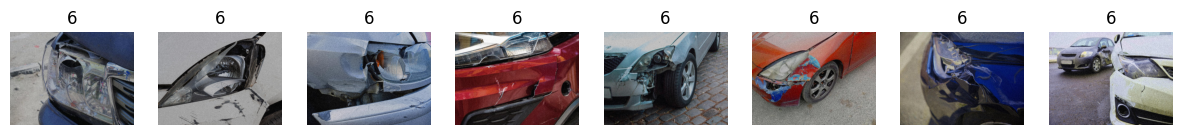

In [3]:
# let's see what out data looks like and corresponding labels
labels_df= pd.read_csv('train/train.csv')
for label_value in range(1,7):
  images= labels_df[labels_df.label==label_value]['filename'][:10].values
  fig, ax = plt.subplots(1, 8, figsize=(15, 8))
  for j in range(8):
          img = mpimg.imread('train/images/' + images[j])
          ax[j].imshow(img)
          ax[j].set_title(label_value)
          ax[j].axis('off')



### visual inspection reveals that 5 represents front glass damage, 3 tire failure, 4 dent in the car and so on

In [4]:
# let's get mean and std of our image data set to normalise
from data_preprocessing import get_mean_std, get_data_loaders
#mean, std = get_mean_std('train/images/')
#Mean: [0.47770813 0.45964807 0.46059614]
#Std: [0.27100051 0.26614914 0.26896046]

In [5]:
labels_df.head()

image_id filename  label
0         1    1.jpg      2
1         2    2.jpg      4
2         3    3.jpg      2
3         4    4.jpg      3
4         5    5.jpg      5

In [6]:
train_loader, test_loader = get_data_loaders(batch_size=16)

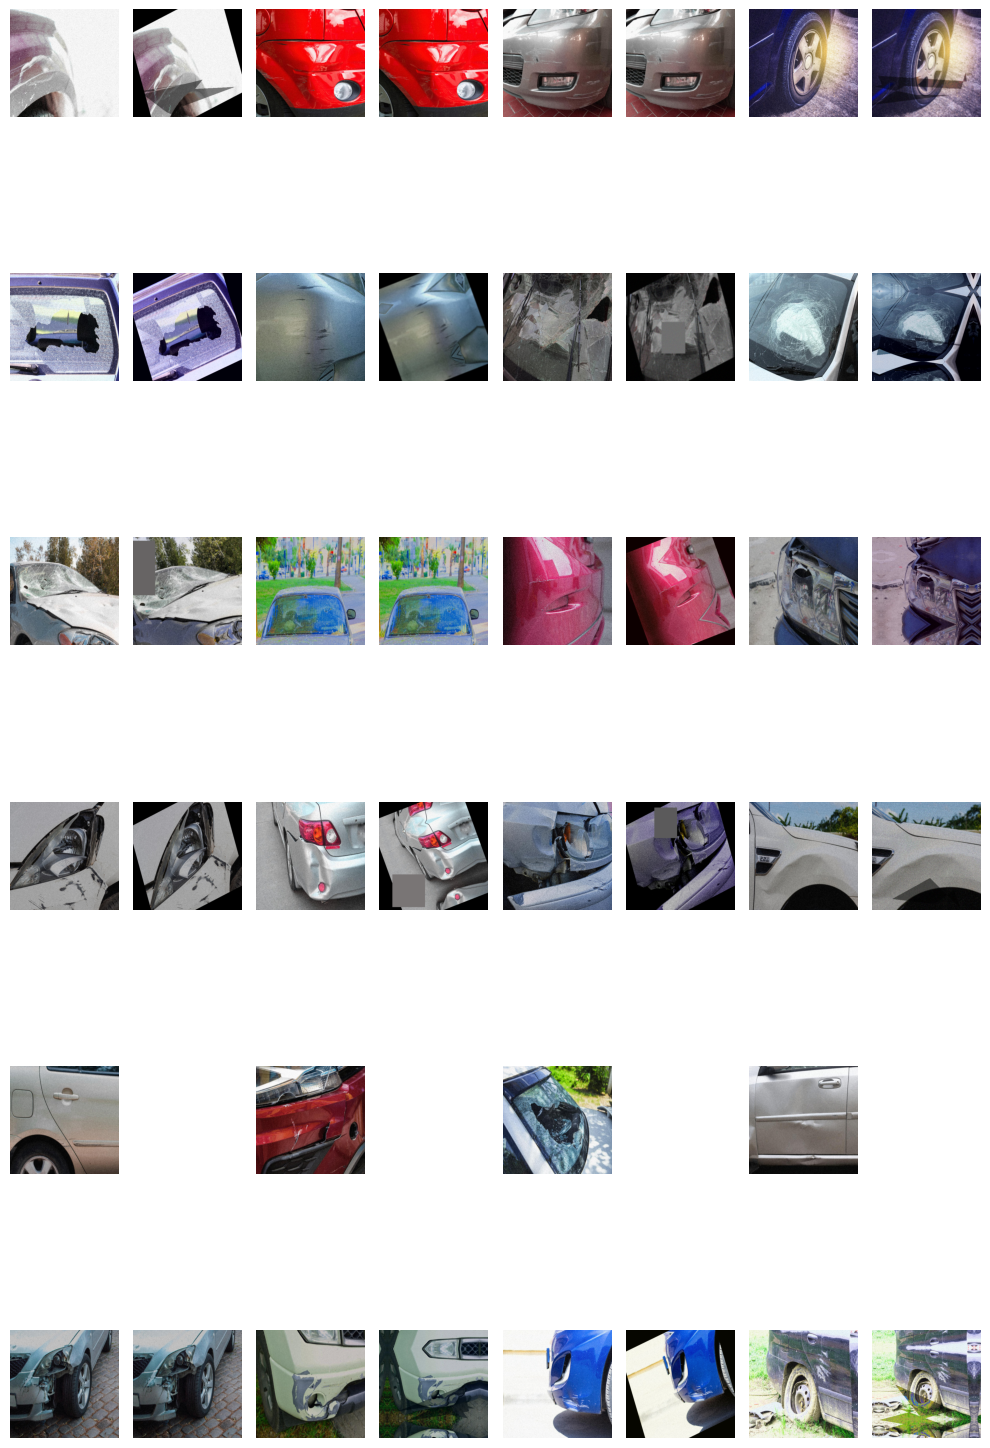

In [16]:
# visualise transformed images
from data_preprocessing import visualise_transformation
visualise_transformation()

In [8]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.0 MB/s eta 0:00:00


In [7]:
# let's use transfer learning to pretrain 1 of the top model for classification

import torch
import torch.nn as nn
import timm
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained EfficientNet model
model = timm.create_model('efficientnet_b4', pretrained=True)

num_classes = 6  # Replacing with our number of classes


model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model.to(device)

# Freeze the parameters (weights) of the features layers (optional, based on your strategy)
for param in model.parameters():
    param.requires_grad = True

# Enable training for the parameters of the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True



In [12]:



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1  # Number of training epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        # Forward pass
        images,labels= images.to(device),labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate accuracy
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

        # Backward and optimize

        loss.backward()
        optimizer.step()

        train_accuracy = 100 * train_correct / train_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%')



Epoch [1/1], Loss: 0.4831, Training Accuracy: 81.25%
Epoch [1/1], Loss: 0.1309, Training Accuracy: 87.50%
Epoch [1/1], Loss: 0.0767, Training Accuracy: 91.67%
Epoch [1/1], Loss: 0.1423, Training Accuracy: 92.19%
Epoch [1/1], Loss: 0.1022, Training Accuracy: 93.75%
Epoch [1/1], Loss: 0.4062, Training Accuracy: 92.71%
Epoch [1/1], Loss: 0.3143, Training Accuracy: 92.86%
Epoch [1/1], Loss: 0.2215, Training Accuracy: 92.97%
Epoch [1/1], Loss: 0.4973, Training Accuracy: 93.06%
Epoch [1/1], Loss: 0.3150, Training Accuracy: 93.12%
Epoch [1/1], Loss: 0.8226, Training Accuracy: 92.05%
Epoch [1/1], Loss: 0.3126, Training Accuracy: 92.19%
Epoch [1/1], Loss: 0.2963, Training Accuracy: 91.83%
Epoch [1/1], Loss: 0.3528, Training Accuracy: 91.52%
Epoch [1/1], Loss: 0.2197, Training Accuracy: 91.67%
Epoch [1/1], Loss: 0.2229, Training Accuracy: 91.80%
Epoch [1/1], Loss: 0.2168, Training Accuracy: 91.91%
Epoch [1/1], Loss: 0.0802, Training Accuracy: 92.36%
Epoch [1/1], Loss: 0.5525, Training Accuracy: 

In [13]:

torch.save(model, 'ripik_model.pth')
# model = torch.load('ripik_model.pth', map_location=torch.device('cpu'))
# model.eval()

In [14]:
model.eval()  # Set the model to evaluation mode

predictions = []
for images, img_names in test_loader:
    images= images.to(device)
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(zip(img_names, predicted.cpu().numpy()))  # Store image names and predictions

In [15]:
df_test= pd.read_csv('test/test.csv')
df_pred = pd.DataFrame(predictions)
df_pred.columns= ['filename','label']
df_pred['label']+=1
print(df_pred['label'].value_counts())
df_pred.head()
df_combined= df_test.merge(df_pred,left_on= 'filename', right_on= 'filename')
df_combined[['image_id','label']].to_csv('submission.csv',index=False)

df_combined.head()



4    1550
2    1381
5     792
6     668
3     358
1      51
Name: label, dtype: int64


image_id  filename  label
0      7201  7201.jpg      6
1      7202  7202.jpg      6
2      7203  7203.jpg      4
3      7204  7204.jpg      5
4      7205  7205.jpg      4

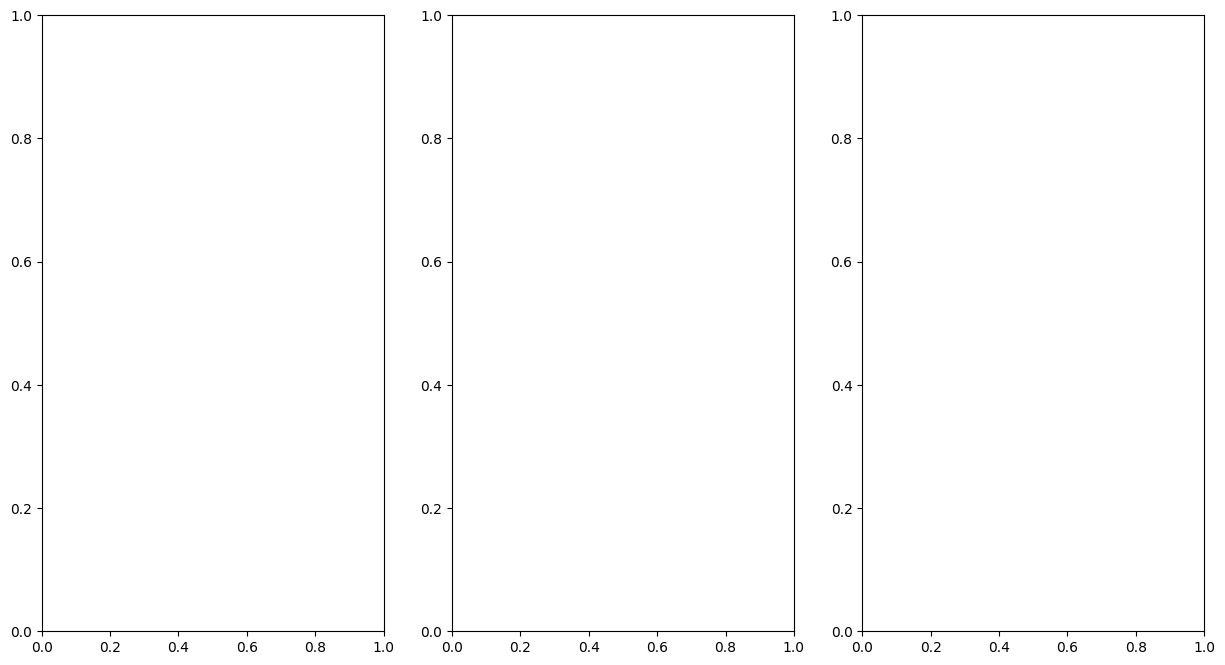

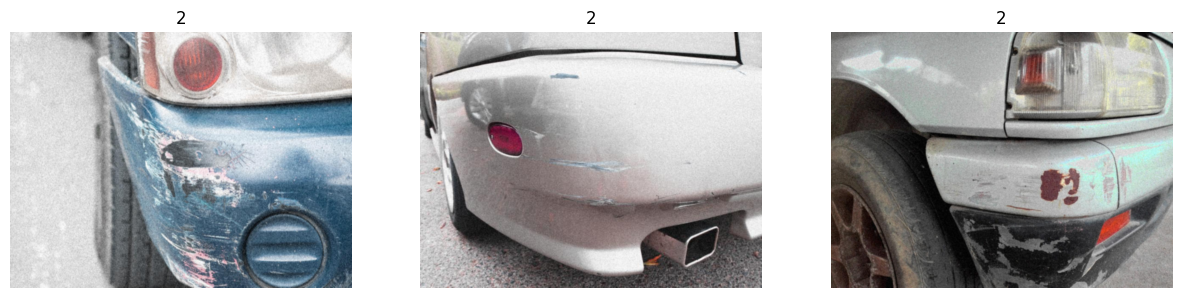

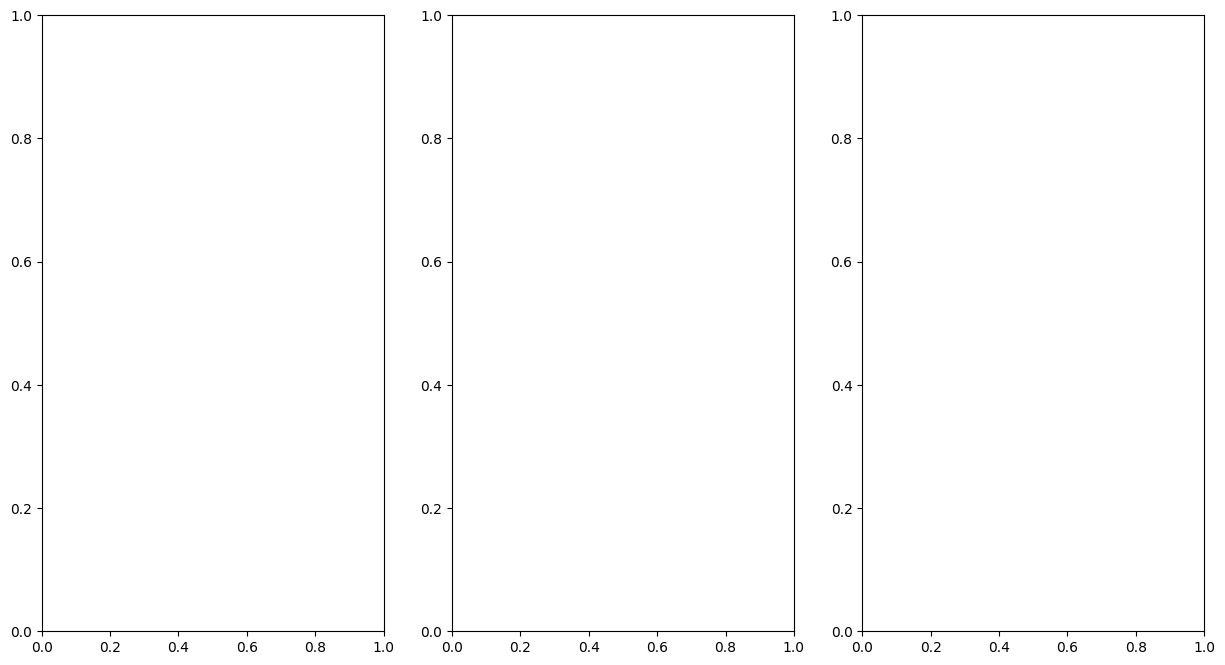

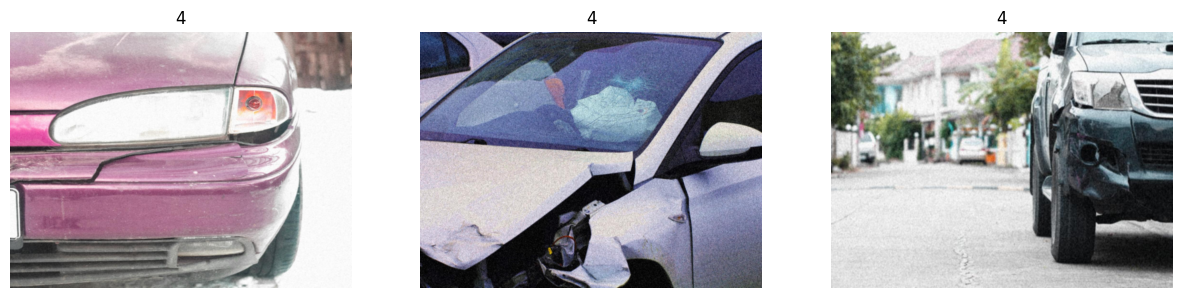

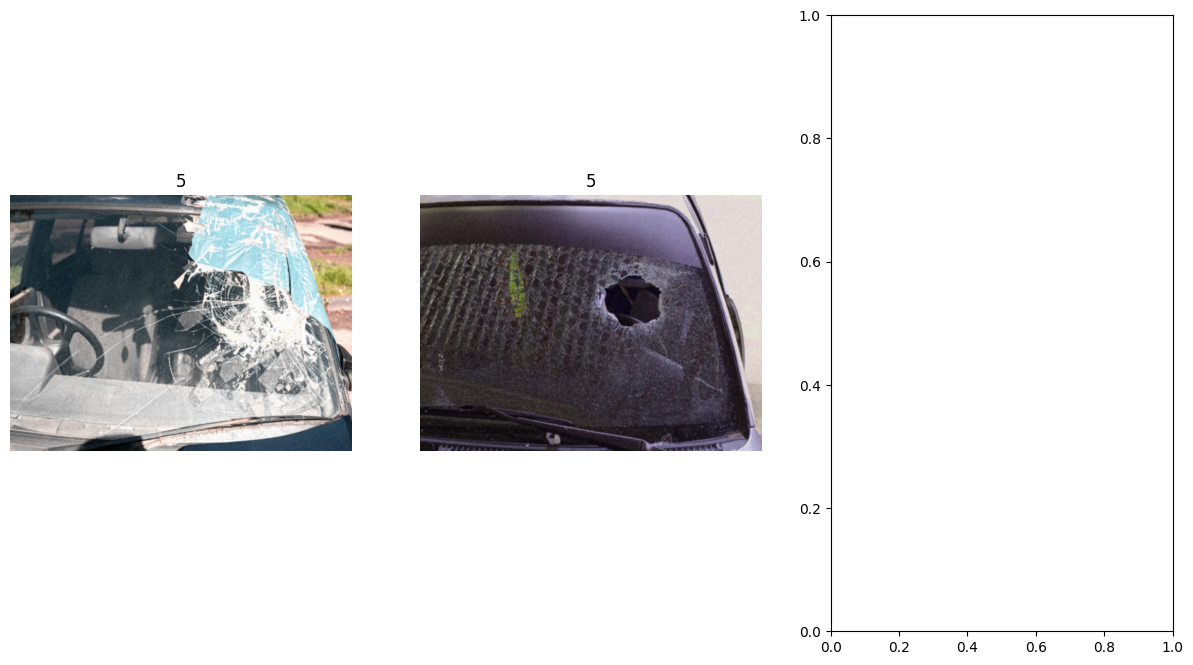

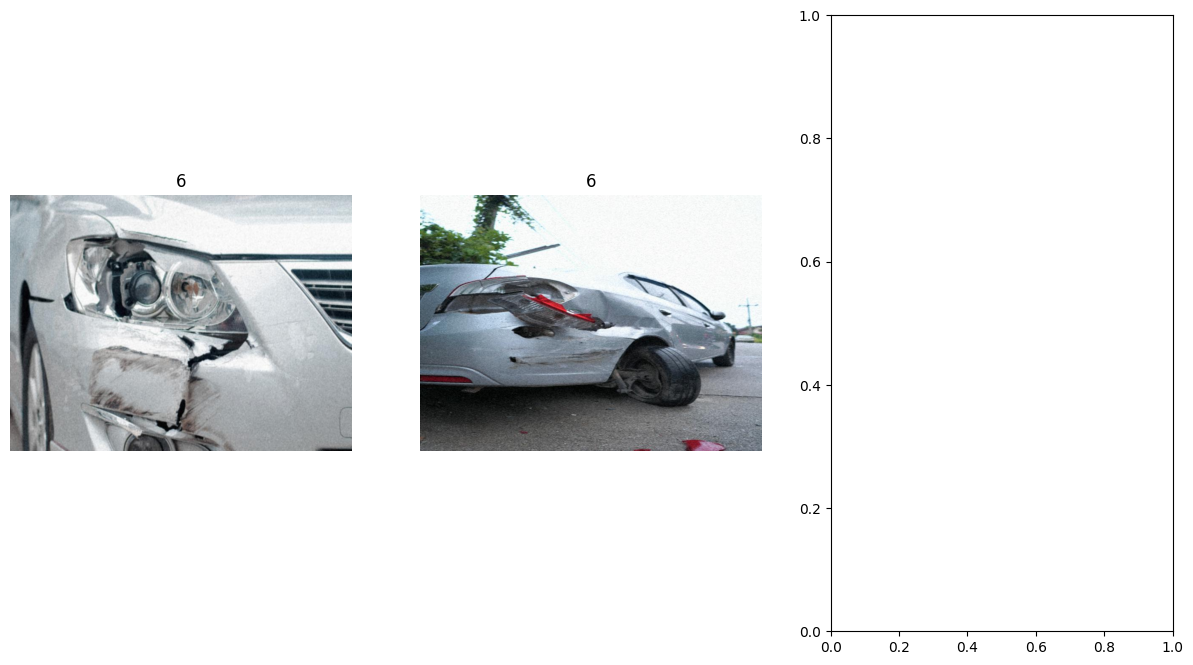

In [32]:
# let's see what our model is predicting

model.eval()  # Set the model to evaluation mode

predictions = []
images, img_names = next(iter(test_loader))
images= images.to(device)
with torch.no_grad():
    outputs = model(images)
_, predicted = torch.max(outputs, 1)
predictions.extend(zip(img_names, predicted.cpu().numpy()))  # Store image names and predictions

df_vis= pd.DataFrame(predictions)
df_vis.columns= ['filename','label']
df_vis['label']+=1

for label_value in range(1,7):
  files= df_vis.loc[df_vis.label==label_value,'filename'].values
  fig, ax = plt.subplots(1, 3, figsize=(15, 8))
  for j in range(3):
    try:
          img = mpimg.imread('test/images/' + files[j])
          ax[j].imshow(img)
          ax[j].set_title(label_value)
          ax[j].axis('off')
    except:
      continue

In [13]:

# let's see f1 score on our training dataset

model.eval()

predictions = []
for images, img_names in train_loader:
    images= images.to(device)
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(zip(img_names, predicted.cpu().numpy()))  # Store image names and predictions

0.9708333333333333


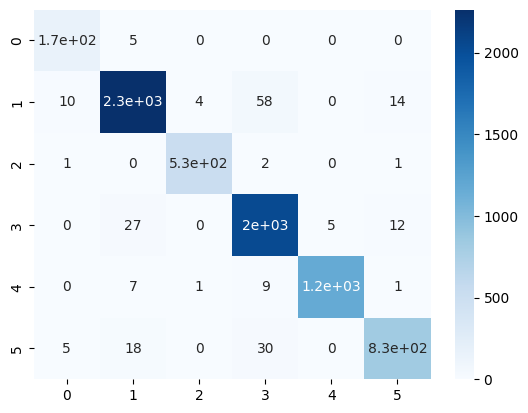

In [14]:
# get the f1 score



y_true = [x[0] for x in predictions]
y_pred = [x[1] for x in predictions]

# make a contingency table
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

# make the matrix color coded for easy visualisation
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, ax = ax, cmap='Blues'); #annot=True to annotate cells

print(f1_score(y_true, y_pred, average='micro'))